<a href="https://colab.research.google.com/github/musicjae/recommender-system/blob/main/recommender_system_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 글은 [캐글 추천 시스템 튜토리얼](https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system)을 정리한 것이다.  
 [추가 참고 출처](https://github.com/lsjsj92/recommender_system_with_Python/blob/master/003.%20recommender%20system%20basic%20with%20Python%20-%202%20Collaborative%20Filtering.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 소개  
  
정보 필터링 시스템의 한 부류인 추천 시스템recommendation systems은 사용자가 부여하는 평점ratings, 선호도preference를 예측하는 시스템이다. Amazon은 상품을 추천해주고, Youtube는 다음 재생될 영상을 추천해주고, facebook은 다음에 추가할 친구를 추천해주고, Netflix는 사용자가 선호할 만한 영상을 추천해준다.

## 1.2 세 가지 필터링 방법들  
  
- Demographic 필터링  
  - 동일한 demographic 특징을 가진 모든 유저들에게 동일한 item을 추천
  
- Content 기반 필터링  
  - 어떤 유저 x에 대하여, 그 유저가 특정 아이템 i를 선호한다면, 그것과 유사한 아이템 j를 추천
  
- 협동적Collaborative 필터링  
   - 유저 x,y,z가 유사한 관심사를 갖는다면, 이 매칭x,y,z에 기초로 하여 item을 추천. 

# 2. Small Project  
  
  
- 특정 유저에게 영화 추천해주기 (추천 알고리즘 만들기)
  
  - Datasets: 이미 잘 만들어진 Kaggle dataset 내에 있는 tmdb_5000_Movie_Dataset을 가지고 모델을 학습시킨 뒤, 그 모델을 이용하여 특정 유저에게 영화를 추천해준다. 이것은 아마존닷컴의 자회사인 IMDb에서 수집한 자료다. 

In [2]:
import pandas as pd 
import numpy as np
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from IPython.display import Image

In [4]:
df1 = pd.read_csv('/content/drive/My Drive/datasets/Movie_Dataset/tmdb_5000_credits.csv')
df2 = pd.read_csv('/content/drive/My Drive/datasets/Movie_Dataset/tmdb_5000_movies.csv')

In [ ]:
df1.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [ ]:
df2.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [ ]:
df1.head(5)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
df2.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [ ]:
df2.merge(df1).head(3) # df2 뒤에 df1 붙인다.

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


## 2.1 인구통계학적 필터링 Demographic Filtering

- IMDB 사의 평점 식  
![](https://image.ibb.co/jYWZp9/wr.png)
  
  where,  
  * v is the number of votes for the movie;
  * m is the minimum votes required to be listed in the chart;
  * R is the average rating of the movie; And
  * C is the mean vote across the whole report

In [ ]:
# v, R은 이미 가지고 있다.
# C 구하기
C=df2['vote_average'].mean() # 각 영화들이 받은 평균 평점 전체에 대하여 평균을 구한다.
print(C)

6.092171559442011


In [ ]:
m= df2['vote_count'].quantile(0.9) # 리스트 내의 영화들이 적어도 90% 보다 더 많이 투표수를 얻어야 하게끔 "요구 최소 투표수"를 설정한다. (cutoff로 90% 설정)
print(m)

# quantile은 오름차순 정렬 시 0 - 1 사이에 있는 q 값에 따라 정렬해준다.
# 이것을 사용함으로써 선호되는 영화id만을 선택할 수 있다.

1838.4000000000015


득표수 상위 90%인 영화의 개수는 상위 481 개이다.


In [ ]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 20)

### IMDB의 추천 알고리즘 식 적용 

In [ ]:
def weighted_rating(x,m=m,C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

상위 90&에 랭크된 영화 제목들만을 출력

In [ ]:
cnt=0
for i in q_movies['original_title']:
    if (cnt <5):
        print(i)
    cnt +=1

Avatar
Pirates of the Caribbean: At World's End
Spectre
The Dark Knight Rises
John Carter


In [ ]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [ ]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


In [ ]:
df2.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

#### 가장 인기 있던 영화 추천 목록

Text(0.5, 1.0, 'Popular Movies')

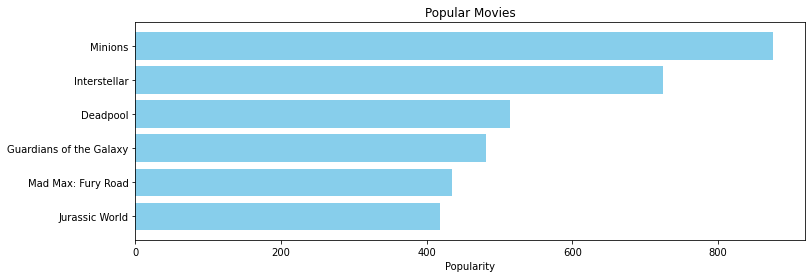

In [ ]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

#### 가장 수익이 좋았던 영화 추천 목록

Text(0.5, 1.0, 'revenue')

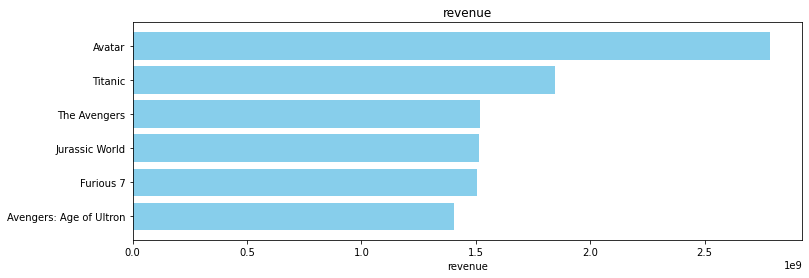

In [ ]:
pop= df2.sort_values('revenue', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['revenue'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("revenue")
plt.title("revenue")

#### 득표 수가 가장 많은 영화 목록

Text(0.5, 1.0, 'vote_count')

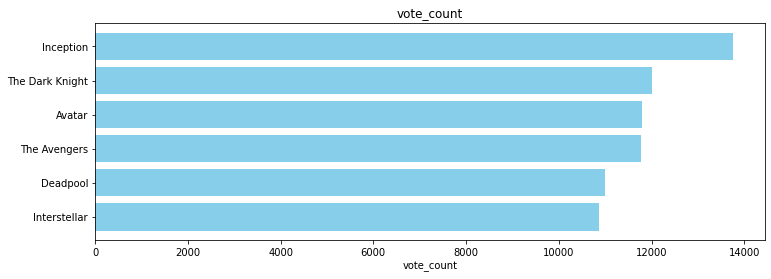

In [ ]:
pop= df2.sort_values('vote_count', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['vote_count'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("vote_count")
plt.title("vote_count")

## 2.2 컨텐츠 기반 필터링 Content Based Filtering

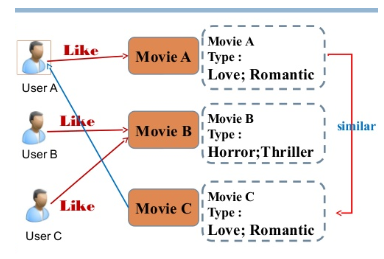

In [ ]:
Image('/content/drive/My Drive/datasets/img/recommender/contentfiltering.PNG')

컨텐츠 기반 필터링은 유저가 이미 선호하고 있는 영화 A의 장르가 '로맨틱'이라면, 그 A와 동일한 장르인 영화 C를 추천해준다. 우리는 여기서 영화 plot에 대한 설명 간 유사도 측정을 통해 추천 시스템을 만들고자 한다.

In [ ]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

### TF-IDF

TF-IDF 를 이용하여 문서-단어-행렬DTM 내 각 단어의 중요도를 구하고, 이것을 이용하기 위해 임포트하는 함수를 통해 불용어를 제거한다. 불용어의 제거는 중요한 단어들에 대해서만 조사할 수 있게 해주기 때문에 우리가 필요한 정보만을 추출하고자 할 때 도움을 준다.

- 불용어stopword: 갖고 있는 데이터에서 유의미한 단어 토큰만을 선별하기 위해 큰 의미가 없는 단어 토큰을 제거해야 한다. 조사, 접미사 같은 단어들은 문장에서는 자주 등장하지만 실제 의미 분석을 하는데는 거의 기여하는 바가 없다. [출처](https://settlelib.tistory.com/49#:~:text=%EB%B6%88%EC%9A%A9%EC%96%B4(Stopword),%EB%8B%A8%EC%96%B4%EB%93%A4%EC%9D%84%20%EB%B6%88%EC%9A%A9%EC%96%B4%EB%9D%BC%20%ED%95%9C%EB%8B%A4.)

**TF-IDF**(Term Frequency-Inverse Document Frequency)를 이용하여 각 overview에 대한 컨텐츠 기반 필터링을 수행해보자.  
  
-  term frequency: term instance로 주어진 doc 내의 단어의 상대적 빈도수  
-  Inverse Document Frequency: $log(\frac{num\_documents}{documents\_with\_term})$  
- TF-IDF: The overall importance of each word to the documents 

위의 결과는 행렬로 제공된다.  

- 각 column은 overview 단어 집합 내의 각 word를 표현  
- 각 row은 하나의 영화를 표현  
  
이 수행은 plot overviews 내에서 빈번하게 나타나는 단어들(불용어)를 제거하기 위해 수행된다.

In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

4000 여 개의 영화가 있고, 각 영화마다 약 20000 개의 단어로 설명되어 있다.

### 영화 간 유사도 측정

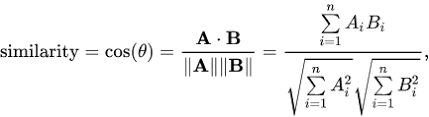

두 개의 영화 사이의 유사도를 나타내는 수치를 구하기 위해 코사인 유사도를 사용한다. 이것은 두 영화가 얼마나 유사한 지에 대한 수치적 정보를 제공한다.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)
print(cosine_sim.shape)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.02160533 0.         0.        ]
 [0.         0.         1.         ... 0.01488159 0.         0.        ]
 ...
 [0.         0.02160533 0.01488159 ... 1.         0.01609091 0.00701914]
 [0.         0.         0.         ... 0.01609091 1.         0.01171696]
 [0.         0.         0.         ... 0.00701914 0.01171696 1.        ]]
(4803, 4803)


### 추천 시스템 함수 만들기

- pandas.series: One-dimensional ndarray with axis labels (including time series).

In [ ]:
title_indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()
print(title_indices[0:5])

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64


#### 절차  
  
- (1) 영화 제목에 대한 인덱스 얻기  
- (2) 모든 영화를 가지고 특정 영화에 대한 유사도 점수 리스트 구하기  
- (3) (2)의 결과를 가지고, (position, score)로 변환  
- (4) sort  
- (5) top 10 list (indices)
- (6) indices of top 10 --> words

In [ ]:
def get_recommendation(title, cosine_sim=cosine_sim):

    # 입력된 특정 영화 제목에 대한 인덱스 구하기
    index = title_indices[title]

    # 유사도 리스트 구하기
    sim_scores = list(enumerate(cosine_sim[index])) # 더 알아보자

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [ ]:
index = title_indices['The Dark Knight Rises']

sim_scores = list(enumerate(cosine_sim[index])) # 더 알아보자

print(index)
print(len(sim_scores))
print(sim_scores[0:5])

3
4803
[(0, 0.0249951158376727), (1, 0.0), (2, 0.0), (3, 1.0), (4, 0.010433403719159354)]


In [ ]:
get_recommendation('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [ ]:
enter = str(input())
print('추천 영화 리스트는 아래와 같습니다: \n\n',get_recommendation(enter))

The Dark Knight Rises
추천 영화 리스트는 아래와 같습니다: 

 65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object


## 2.3 협업적 필터링 Collaborative Filtering

### 2.3.1 컨텐츠 기반 필터링이 가진 곤경  
  
- 위에서 알아본 컨텐츠 기반 필터링에는 제약이 있다. 이것은 특정 영화와 가까운 영화만을 제안할 수 있기 때문이다. 즉, 이것은 다른 장르에 대한 영화 추천에 대해 고려할 수 없다. 
  
- 또한, 컨텐츠 기반 필터링은 개인의 취향, 편향을 포착하지 못하기 때문에 개인 별 맞춤 서비스를 제공하기 어렵다.

### 2.3.2 협업적 필터링  
 - (1) 유저 기반 필터링  
  > 두 유저 간 유사도를 측정하기 위해, 우리는 유저 간 코사인 유사도 또는 상관관계를 구한다.
 - (2) 아이템 기반 필터링  
  > 타겟 유저가 평가한 영화의 평점을 기반으로 하여 영화 간 유사도를 측정한 뒤, 높은 유사도를 가진 영화를 추천

#### 2.3.2.1 유저 기반 필터링  
  
![](https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png)

유저 E를 타겟으로 둘 때, B, C 보다 A,D,F는 공통된 취향을 갖고 있지 않아 보인다.   
![](https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png)

유저 기반 필터링이 가진 문제점:  
- 유저의 선호도는 시간이 지남에 따라 변할 수 있는데, 이 필터링 방법은 그것을 포착하지 못한다. 이것은 주변 유저들을 기초로 행렬을 사전 계산하는 방법이 안 좋은 성능을 제공할 수 있음을 시사한다.  
  
위 문제를 해결하기 위해 2.3.2.2 를 알아보자.

#### 2.3.2.2 아이템 기반 협업적 필터링  
  
![](https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png)

##### 문제점 
- Scalability  
 > 계산량이 유저, 상품 개수에 따라 크게 증가  
- Sparsity  
 >  영화 평가가 적은 경우에, 두 개의 많이 다른 영화가 높은 유사도 점수를 가질 수 있다.

### 2.3.3 SVD  
  
One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem.

## 2.4 실행

In [11]:
df3=pd.read_csv('/content/drive/My Drive/datasets/Movie_Dataset/ratings_small.csv')

In [12]:
df3.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [13]:
df3.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


#### 사용자 별 영화 Id 구하기

#### user-item table

##### (1) user 구하기

In [16]:
data=df3.pivot_table('rating',index='userId',columns='movieId')

In [17]:
data.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,...,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### (2) 영화 title 구하기

In [18]:
ratings = pd.read_csv('/content/drive/My Drive/datasets/Movie_Dataset/ratings_small.csv')
movies = pd.read_csv('/content/drive/My Drive/datasets/Movie_Dataset/tmdb_5000_movies.csv')

In [94]:
movies.head(2)

,budget,genres,homepage,movieId,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [89]:
cnt=1
for i in movies['original_title']:
    if i == 'Interstellar':
        print(cnt)
    cnt += 1


96


In [73]:
movies.rename(columns={'id':'movieId'}, inplace=True)

In [74]:
ratings_movies = pd.merge(ratings, movies, on = 'movieId')

In [75]:
ratings_movies.shape

(18571, 23)

각 사용자 마다 한 영화에 대해 다르게 평점을 매긴 것을 확인

In [76]:
ratings_movies[{'userId','movieId','rating'}].head(10)

,rating,userId,movieId
0,4.0,1,2105
1,4.0,4,2105
2,4.0,15,2105
3,2.0,30,2105
4,4.0,34,2105
5,3.5,35,2105
6,5.0,41,2105
7,3.0,49,2105
8,1.0,59,2105
9,3.0,73,2105


##### (3) user-movie title로 된 table 작성

In [77]:
data = ratings_movies.pivot_table('rating',index='userId',columns='title').fillna(0)#Nan을 0으로 채우기

In [78]:
data.head()

title,10 Things I Hate About You,12 Angry Men,1408,15 Minutes,16 Blocks,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2046,21 Grams,25th Hour,28 Days Later,28 Weeks Later,300,"4 Months, 3 Weeks and 2 Days",40 Days and 40 Nights,42nd Street,5 Days of War,50 First Dates,54,8 Mile,8 Women,88 Minutes,A Beautiful Mind,A Bridge Too Far,A Christmas Story,A Dangerous Method,A Few Good Men,A Fistful of Dollars,A Hard Day's Night,A History of Violence,A Mighty Heart,A Nightmare on Elm Street,A Scanner Darkly,A Streetcar Named Desire,A Time to Kill,A Very Long Engagement,A View to a Kill,"A Woman, a Gun and a Noodle Shop",About Schmidt,About a Boy,...,True Romance,Twilight,Twister,Two Brothers,Two Girls and a Guy,Two Weeks Notice,U-571,Under Siege 2: Dark Territory,Underworld,Underworld: Evolution,Valkyrie,Vanilla Sky,Veer-Zaara,Vicky Cristina Barcelona,Videodrome,Volver,Wag the Dog,Walk the Line,War of the Worlds,Wasabi,Wayne's World,We Own the Night,We're No Angels,Whale Rider,What Lies Beneath,What Women Want,What's Eating Gilbert Grape,When Harry Met Sally...,Wild Things,Wild Wild West,Willy Wonka & the Chocolate Factory,World Trade Center,X-Men Origins: Wolverine,Y Tu Mamá También,You Only Live Twice,"You, Me and Dupree",Young Frankenstein,Zodiac,eXistenZ,xXx
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
print(f'유저 수:{data.shape[0]}, 영화 수:{data.shape[1]}')

유저 수:670, 영화 수:856


##### (4) transpose  
  
아이템 기반 협업 필터링인 경우에, column이 userId를 담고 있어야 한다. 이것을 해결하기 위해 transpose를 취해준다.

In [80]:
data=data.transpose()
data.head(3)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
data.shape

(856, 670)

### 영화들 간의 유사도 구하기  
  
각 사용자가 여러 영화들에 대해 매긴 평점을 고려하여, 영화들 간의 유사도를 구한다.

In [82]:
movie_sim = cosine_similarity(data, data)
print(movie_sim[0:3])
print(movie_sim.shape)

[[1.         0.         0.         ... 0.         0.         0.01412134]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]]
(856, 856)


In [83]:
movie_sim_df = pd.DataFrame(data = movie_sim, index = data.index, columns = data.index)

In [84]:
movie_sim_df.head(3)

title,10 Things I Hate About You,12 Angry Men,1408,15 Minutes,16 Blocks,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2046,21 Grams,25th Hour,28 Days Later,28 Weeks Later,300,"4 Months, 3 Weeks and 2 Days",40 Days and 40 Nights,42nd Street,5 Days of War,50 First Dates,54,8 Mile,8 Women,88 Minutes,A Beautiful Mind,A Bridge Too Far,A Christmas Story,A Dangerous Method,A Few Good Men,A Fistful of Dollars,A Hard Day's Night,A History of Violence,A Mighty Heart,A Nightmare on Elm Street,A Scanner Darkly,A Streetcar Named Desire,A Time to Kill,A Very Long Engagement,A View to a Kill,"A Woman, a Gun and a Noodle Shop",About Schmidt,About a Boy,...,True Romance,Twilight,Twister,Two Brothers,Two Girls and a Guy,Two Weeks Notice,U-571,Under Siege 2: Dark Territory,Underworld,Underworld: Evolution,Valkyrie,Vanilla Sky,Veer-Zaara,Vicky Cristina Barcelona,Videodrome,Volver,Wag the Dog,Walk the Line,War of the Worlds,Wasabi,Wayne's World,We Own the Night,We're No Angels,Whale Rider,What Lies Beneath,What Women Want,What's Eating Gilbert Grape,When Harry Met Sally...,Wild Things,Wild Wild West,Willy Wonka & the Chocolate Factory,World Trade Center,X-Men Origins: Wolverine,Y Tu Mamá También,You Only Live Twice,"You, Me and Dupree",Young Frankenstein,Zodiac,eXistenZ,xXx
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,1.0,0.0,0.0,0.182153,0.0,0.022069,0.085323,0.0,0.0,0.10349,0.310272,0.083315,0.067017,0.082759,0.000000,0.0,0.0,0.0,0.0,0.0,0.135609,0.191313,0.0,0.064064,0.0,0.135769,0.000000,0.00000,0.0,0.0,0.000000,0.176143,0.209557,0.0,0.197156,0.238711,0.072700,0.0,0.000000,0.0,...,0.013443,0.0,0.0,0.125931,0.0,0.061959,0.358571,0.0,0.000000,0.0,0.155284,0.0,0.0,0.0,0.0,0.000000,0.170907,0.055927,0.059059,0.000000,0.0,0.154715,0.015541,0.220239,0.0,0.087588,0.049447,0.0000,0.0,0.0,0.059856,0.0,0.161801,0.088076,0.0,0.0,0.097588,0.0,0.0,0.014121
12 Angry Men,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.118993,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1408,0.0,0.0,1.0,0.447214,0.0,0.173381,0.028245,0.0,0.0,0.00000,0.231423,0.179605,0.205673,0.270914,0.545545,0.0,0.0,0.0,0.0,0.0,0.173708,0.092401,0.0,0.000000,0.0,0.000000,0.316228,0.57735,0.0,0.0,0.707107,0.040543,0.000000,0.0,0.145215,0.164833,0.297482,0.0,0.928477,0.0,...,0.198030,0.0,0.8,0.129049,0.0,0.165948,0.000000,0.0,0.144799,0.0,0.000000,0.0,0.0,0.0,0.0,0.468165,0.026926,0.000000,0.217500,0.298765,0.0,0.079968,0.000000,0.078176,1.0,0.000000,0.233087,0.5547,0.0,0.0,0.146955,0.0,0.148968,0.140265,0.0,0.0,0.191675,0.0,0.0,0.000000


### 영화 추천 받기

In [85]:
movie_sim_df["2046"].sort_values(ascending=False)[1:10]

title
Fantasia                                 1.000000
King Kong                                0.648886
Apollo 13                                0.600000
The Godfather: Part III                  0.529813
Jurassic Park III                        0.400892
Brazil                                   0.396059
Army of Darkness                         0.385758
The Lord of the Rings: The Two Towers    0.351123
Fight Club                               0.350823
Name: 2046, dtype: float64

In [90]:
movie_sim_df["300"].sort_values(ascending=False)[1:10]

title
Madagascar                        0.414285
Cars                              0.404234
The Curse of the Jade Scorpion    0.399074
The Golden Compass                0.396406
Cinderella Man                    0.394447
Mr. Bean's Holiday                0.381528
Terminator Salvation              0.377705
8 Women                           0.364415
Cat on a Hot Tin Roof             0.363456
Name: 300, dtype: float64